# Tian Xu

## 1. Collect some texts.  Compare them in a number of ways.

I utilized a Kaggle dataset that has 400,000 movie reviews covering 9,366 unique movies on 01/05/2022. For my analysis in this lab 2, I specifically focused on the 2 reviews from one of my favorite movie 'La La Land' which has longest review length.

In [1]:

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Prepare the Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/5018/rottentomatoes-400k.csv')
df = df[(df['Movie'] == 'LA LA LAND') & (df['Review'].str.len() > 250)]


df['Review_index'] = ['Review 1', 'Review 2']
df = df.loc[:, ['Review', 'Review_index']].reset_index(drop=True)

<ipython-input-3-025d6031baaa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review_index'] = ['Review 1', 'Review 2']


### Compare the texts similarity 
Using the cosine similarities to compare the 2 review texts

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer()
reviews_vectors = tfidf.fit_transform(df['Review'])

# calculate pairwise cosine similarities between the reviews
cosine_similarities = cosine_similarity(reviews_vectors)

cosine_similarities_df = pd.DataFrame(cosine_similarities, index=df['Review_index'], columns=df['Review_index'])

cosine_similarities_df 


Review_index,Review 1,Review 2
Review_index,,
Review 1,1.000000,0.191036
Review 2,0.191036,1.000000


From the result, we can see that they have somewhat similarity, but not distinct.

### Jaccard similarity

Then compare the Jaccard similarity

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk import word_tokenize
jaccard_similarity = np.zeros((len(df), len(df)))

for i in range(len(df)):
    for j in range(i+1, len(df)):
        review1_words = set(word_tokenize(df.iloc[i]['Review']))
        review2_words = set(word_tokenize(df.iloc[j]['Review']))
        
        # calculate Jaccard similarity between  words
        jaccard_similarity_score = 1 - nltk.jaccard_distance(review1_words, review2_words)
        jaccard_similarity[i, j] = jaccard_similarity_score
        jaccard_similarity[j, i] = jaccard_similarity_score

jaccard_similarity_df = pd.DataFrame(jaccard_similarity, index=df['Review_index'], columns=df['Review_index'])

jaccard_similarity_df


Review_index,Review 1,Review 2
Review_index,,
Review 1,0.000000,0.111111
Review 2,0.111111,0.000000



From the result of the jaccard similarity, we can see that the score was lower than what I got from cosine similarity.

## 2.You will likely want to have them be “bags of words.”  Prepare the text through removing upper case, white space, punctuation, and consider stemming the words, if appropriate for you purpose.  

I will use countVectorizer to do get bags or words .
dtm_df is my bag of words in dataframe format

by: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

### Data preprocessing

In [11]:

nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", " ", text)
    # Remove white spaces
    text = text.strip()
    # Tokenize the text
    words = word_tokenize(text)
    # Stem the words (optional)
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Remove integer
    words = [word for word in words if not word.isnumeric()]

    return " ".join(words)


df['Preprocessed_Review'] = df['Review'].apply(preprocess_text)

### Bags of words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()


# fit and transform the text data
X = vectorizer.fit_transform(list(df['Preprocessed_Review']))

# create a DataFrame from the sparse matrix
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df['Review_index'])


In [14]:
dtm_df

,balanc,chazel,chees,clash,collect,complet,curious,damien,embrac,found,...,self,set,sincer,step,style,time,tradit,way,whimsic,world
Review_index,,,,,,,,,,,,,,,,,,,,,
Review 1,1,0,1,1,1,1,0,0,1,0,...,0,0,1,0,1,0,1,2,1,0
Review 2,0,1,0,0,0,0,1,1,0,1,...,1,1,0,1,0,1,0,0,0,1


## 3. Generate relative word frequencies for each bag of words, and compare them to each other.

In [15]:
dtm_T = dtm_df.T

# Allow words to be a column instead of the index
dtm_T.reset_index(drop=False, inplace=True)
dtm_T.rename(columns={'index': 'words'}, inplace=True)

dtm_T['Review_1_prop'] = dtm_T['Review 1'].apply(lambda x: x/dtm_T['Review 1'].sum())
dtm_T['Review_2_prop'] = dtm_T['Review 2'].apply(lambda x: x/dtm_T['Review 2'].sum())
dtm_T['Reviwe1_over_Review2'] = dtm_T.Review_1_prop - dtm_T.Review_2_prop
dtm_T

Review_index,words,Review 1,Review 2,Review_1_prop,Review_2_prop,Reviwe1_over_Review2
0,balanc,1,0,0.035714,0.000000,0.035714
1,chazel,0,1,0.000000,0.052632,-0.052632
2,chees,1,0,0.035714,0.000000,0.035714
3,clash,1,0,0.035714,0.000000,0.035714
4,collect,1,0,0.035714,0.000000,0.035714
5,complet,1,0,0.035714,0.000000,0.035714
6,curious,0,1,0.000000,0.052632,-0.052632
7,damien,0,1,0.000000,0.052632,-0.052632
8,embrac,1,0,0.035714,0.000000,0.035714
9,found,0,1,0.000000,0.052632,-0.052632


## 4. Articulate what differences (if any) you notice and whether this comports with a theory of why these bags of words should be similar or different.

By looking at top 10 frequency words in Review 1, we can find that review 2 has none of them. Also, review 1 does not have any words in the top 10 frequent words in review 2. This may indicate that even though these writers comment on same movie "La La Land," they may review differently. They may have differnt ideas, writing styles, interests, or preferences. We can also see that review 1 has more words on the technical sides of the movie, while review 2 focus more on the emotion.


Therefore, the bags of words should be different.

In [16]:

dtm_T.sort_values('Review 1', ascending=False, inplace=True)
dtm_T.head(10)

Review_index,words,Review 1,Review 2,Review_1_prop,Review_2_prop,Reviwe1_over_Review2
20,meet,4,0,0.142857,0.0,0.142857
39,way,2,0,0.071429,0.0,0.071429
17,la,2,0,0.071429,0.0,0.071429
0,balanc,1,0,0.035714,0.0,0.035714
15,idea,1,0,0.035714,0.0,0.035714
40,whimsic,1,0,0.035714,0.0,0.035714
38,tradit,1,0,0.035714,0.0,0.035714
36,style,1,0,0.035714,0.0,0.035714
34,sincer,1,0,0.035714,0.0,0.035714
31,romanc,1,0,0.035714,0.0,0.035714


In [17]:
dtm_T.sort_values('Review 2',ascending=False, inplace=True)
dtm_T.head(10)

Review_index,words,Review 1,Review 2,Review_1_prop,Review_2_prop,Reviwe1_over_Review2
41,world,0,1,0.0,0.052632,-0.052632
30,retro,0,1,0.0,0.052632,-0.052632
14,hollywood,0,1,0.0,0.052632,-0.052632
7,damien,0,1,0.0,0.052632,-0.052632
37,time,0,1,0.0,0.052632,-0.052632
35,step,0,1,0.0,0.052632,-0.052632
6,curious,0,1,0.0,0.052632,-0.052632
33,set,0,1,0.0,0.052632,-0.052632
32,self,0,1,0.0,0.052632,-0.052632
28,rambl,0,1,0.0,0.052632,-0.052632


## 5. Run statistical tests of association between the bags of words (correlation, cosine similarity, regression or Chi-squared), and explain what they indicate.

### Correlation
The correlation between the two reviews is -0.780189, indicating a strong negative relationship. This suggests that as the frequency of a word increases in Review 1, it decreases in Review 2.

In [18]:
dtm_df.T.corr(method='pearson')

Review_index,Review 1,Review 2
Review_index,,
Review 1,1.000000,-0.780189
Review 2,-0.780189,1.000000


### cosine similarity
The cosine similarity between the two reviews is 0.191036, this is not high, meaning that two reviews may not have a lof of similar words

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity=cosine_similarity(dtm_df)
pd.DataFrame(cosine_similarities, index=df['Review_index'], columns=df['Review_index'])

Review_index,Review 1,Review 2
Review_index,,
Review 1,1.000000,0.191036
Review 2,0.191036,1.000000


### regression
The regression model shows that the coefficient for Review 2 is -1.2174, showing a strong negative relationship between the two reviews, the p-value indicates that this is statistically significant. 

In [20]:
# Rename columns to avoid errors in regression model specification
dtm_T2 = dtm_T.rename(columns={'Review 1': 'Review_1', 'Review 2': 'Review_2'})
from statsmodels.regression.linear_model import OLS

m1a = OLS.from_formula('Review_1 ~ Review_2', data=dtm_T2).fit()
m1a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Review_1   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     62.22
Date:                Sat, 25 Mar 2023   Prob (F-statistic):           1.12e-09
Time:                        16:40:11   Log-Likelihood:                -29.275
No. Observations:                  42   AIC:                             62.55
Df Residuals:                      40   BIC:                             66.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2174      0.104     11.728      0.000       1.008       1.427
Review_2      -1.2174      0.154     -7.888      0.000      -1.529      -0.905
==============================================================================
Omnibus:                       77.004   Durbin-Watson:                   2.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1072.886
Skew:                           4.630   Prob(JB):                    1.06e-233
Kurtosis:                      25.964   Cond. No.                         2.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Chi-squared
 The Chi-square test statistic is 42.0, with a very low p-value. This shows that two texts are significant different from each other.

In [21]:
import scipy as sp
dtm_cont = pd.crosstab(dtm_df.T['Review 1'], dtm_df.T['Review 2'])
chi2_stat, p_val, dof, ex = sp.stats.chi2_contingency(dtm_cont.values)
chi2_stat, p_val

(42.0, 4.012126658231684e-09)

## 6. Do one more big thing-- either a sentiment analysis of the bags of words; rerun your analysis but using bigrams and/or trigrams; consider the role of negation words (“not,” “no”, etc.) on your earlier analysis; run a parts of speech tagger; look at the temporal unfolding of your words; or do a topic modelling exercise.  For whichever thing you choose, explain what you are doing and whatever you find makes sense in some way theoretically.

I will use all the 285 reviews in the dataset to build the topic modelling.
I will first preprocess the text, then train an LDA model. I will do the hyperparameter tunning to find the most appropariate num_topics and num_words based on the coherence score of the model. 

Use this article as reference:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

### Data Input and Preprocessing

In [29]:
df_topic = pd.read_csv('/content/drive/MyDrive/5018/rottentomatoes-400k.csv')
df_topic = df_topic[(df_topic['Movie'] == 'LA LA LAND') ]

# Preprocessing the data
df_topic['Preprocessed_Review'] = df_topic['Review'].apply(preprocess_text) 
# Tokenize the data
df_topic['Preprocessed_Review'] = df_topic['Preprocessed_Review'].apply(lambda x: x.split())

In [27]:
len(df_topic)

285

### Split the trainning and testing data

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_topic, test_size=0.2, random_state=42)


In [39]:
import gensim

dictionary = gensim.corpora.Dictionary(df_topic['Preprocessed_Review'])

# Create a bag of words representation of the corpus
corpus = [dictionary.doc2bow(review) for review in df_topic['Preprocessed_Review']]


Topic 1: (0, '0.020*"la" + 0.013*"music" + 0.009*"thi"')
Topic 2: (1, '0.020*"music" + 0.019*"movi" + 0.013*"chazel"')


### Hyperparameter tuning
Our best number of topic is 25, with coherence score 0.36


In [45]:
from gensim.models import LdaMulticore, CoherenceModel

# The hyperparameter search space
num_topics_list = [5, 10, 15, 20,25,30]

# Initialize variables 
best_coherence = -1
best_params = None

# Perform hyperparameter tuning
for num_topics in num_topics_list: 
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=42)

  coherence_model_lda = CoherenceModel(model=lda_model, texts=df_topic['Preprocessed_Review'], dictionary=dictionary, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()

  if coherence_lda > best_coherence:
    best_coherence = coherence_lda
    best_params = {'num_topics': num_topics}

print("Best Coherence Score:", best_coherence)
print("Best Hyperparameters:", best_params)


Best Coherence Score: 0.3606006312890194
Best Hyperparameters: {'num_topics': 25}


### Apply the best hyperparameter to lda model

In [46]:
best_lda_model = LdaMulticore(corpus=corpus,
                               id2word=dictionary,
                               num_topics=best_params['num_topics'],
                               random_state=42)

### print top 6 words for each topic

In [47]:

for idx, topic in best_lda_model.print_topics(num_topics=-1, num_words=6):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))

Topic: 1 
Words: 0.021*"classic" + 0.017*"hollywood" + 0.014*"somehow" + 0.014*"love" + 0.012*"la" + 0.010*"music"
Topic: 2 
Words: 0.022*"film" + 0.016*"music" + 0.014*"review" + 0.014*"la" + 0.013*"stone" + 0.012*"love"
Topic: 3 
Words: 0.073*"la" + 0.035*"land" + 0.017*"film" + 0.017*"love" + 0.014*"movi" + 0.014*"music"
Topic: 4 
Words: 0.046*"la" + 0.023*"land" + 0.018*"film" + 0.015*"break" + 0.015*"heart" + 0.015*"grand"
Topic: 5 
Words: 0.057*"la" + 0.025*"music" + 0.024*"land" + 0.018*"film" + 0.015*"chazel" + 0.010*"ga"
Topic: 6 
Words: 0.025*"music" + 0.022*"movi" + 0.016*"film" + 0.016*"feel" + 0.016*"thi" + 0.015*"big"
Topic: 7 
Words: 0.061*"la" + 0.036*"land" + 0.021*"film" + 0.018*"love" + 0.014*"us" + 0.014*"chazel"
Topic: 8 
Words: 0.037*"la" + 0.019*"land" + 0.012*"wonder" + 0.011*"master" + 0.011*"film" + 0.011*"chazel"
Topic: 9 
Words: 0.027*"la" + 0.014*"vibrant" + 0.014*"ovat" + 0.014*"enchant" + 0.014*"alon" + 0.014*"big"
Topic: 10 
Words: 0.023*"music" + 0.021*

### for each document, get the topic assigned by LdaModel

In [48]:

df_topic['lda_topic'] = df_topic['Preprocessed_Review'].apply(lambda x: best_lda_model[dictionary.doc2bow(x)][0][0])

In [49]:
pd.options.display.max_colwidth = 110

###  display a sample of 5 headlines classified as topic 1 by LdaModel

In [52]:

df_topic.loc[df_topic.lda_topic==1, 'Review'].sample(5, random_state=11)

135286    Every moment of La La Land is worth living through because of Stone and Gosling, and Chazelle, whose direc...
135262    A bittersweet musical with scenarios that suppurate a vintage aura inspired by classic Hollywood and with ...
135304    If you haven't already fallen for this gauzy romp through the city of Angels at this point, you surely wil...
135285    The rare kind of spellbinding, wonderful film that has reviewers like me tripping over themselves to find ...
135282    A film that will possibly become the last hero of a dying genre that everybody will be talking about, at l...
Name: Review, dtype: object

###  display a sample of 5 headlines classified as topic 1 by LdaModel

In [53]:

df_topic.loc[df_topic.lda_topic==10, 'Review'].sample(5, random_state=11)

135281    It's as gorgeous in its gloom as in its wonderfully shameless whimsy. It's a dizzying whirlwind of romance...
135402    Visually gorgeous and deliciously colorful, La La Land is a romantically fueled, comically fun, and sympho...
135369       I believe people when they say they are moved or enchanted by the film; it just didn't move or enchant me.
135392    An absolutely top-tier musical and glossy valentine to the simple, blunt-force emotions of classical Holly...
135429     Impressive. But it lumbers along when it's supposed to fly, and groans under the weight of its own ambition.
Name: Review, dtype: object

## Extra credit: do some wordclouds of your texts
I will do wordclouds for all the lala land reviews together

From the word cloud, we  can eaily see that the "Musical," "Love," "Romance," "Dance" are some common mentioned words, which show the topic of la la land movie.

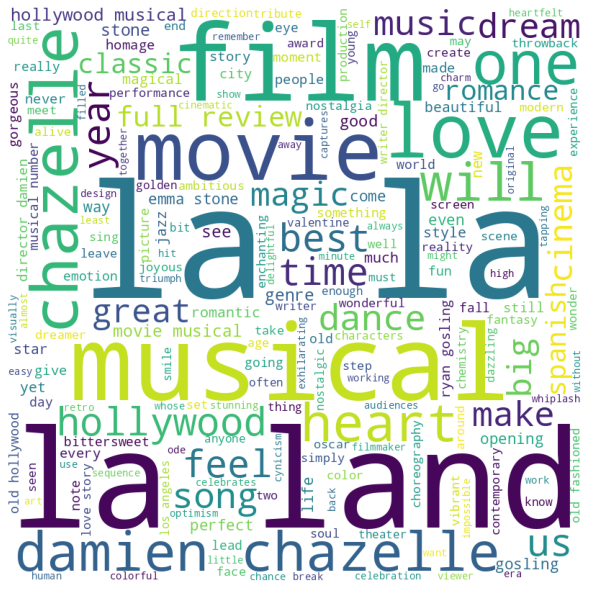

In [57]:
all_reviews = ' '.join(df_topic['Review'].apply(lambda x: x.lower()))
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(all_reviews)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
